In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
#导入数据
train = pd.read_csv(r'titanic\train.csv')
test = pd.read_csv(r'titanic\test.csv')
test_survived = pd.read_csv(r'titanic\gender_submission.csv')
test['Survived'] = test_survived['Survived'] #将测试集的survived拼接
PassengerId = test['PassengerId'] # 测试集的passengerid
all_data = pd.concat([train,test],ignore_index= True) #竖向拼接

D:\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [123]:
#总体预览
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### PassengerID(id) Survived(存活与否) Pclass(客舱等级，较为重要) Name(可提取出更多信息) Sex(性别，较为重要) Age(较为重要) Parch(直系亲友) SibSp(旁系) Ticket(票编号) Cabin(客舱编号)Embarked(上船的港口编号)

In [124]:
train.info() #训练集的相关信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### 数据初步分析，使用统计学和绘图 目的：初步了解数据之间的相关性，为构造特征工程以及模型建立做准备

In [125]:
train['Survived'].value_counts()  #存活与否计数

0    549
1    342
Name: Survived, dtype: int64

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


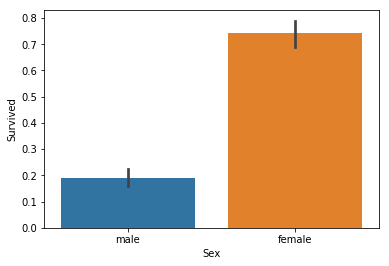

In [126]:
#女性幸存率远高于男性
sns.barplot(x = 'Sex', y = 'Survived',data = train) #柱状图 看男女幸存情况

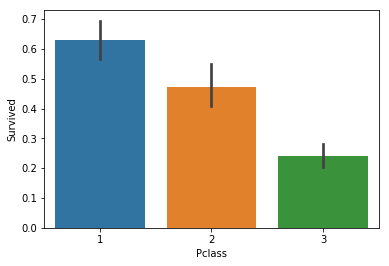

In [127]:
# 乘客社会等级越高，幸存率越高
sns.barplot(x = 'Pclass' , y = 'Survived',data = train)

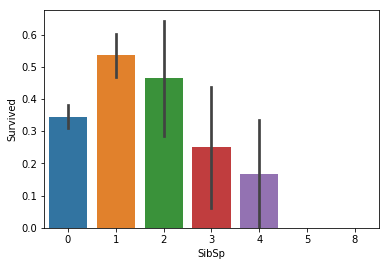

In [128]:
# 配偶及兄弟姐妹数适中的乘客幸存率更高
sns.barplot(x = 'SibSp', y = 'Survived', data = train)

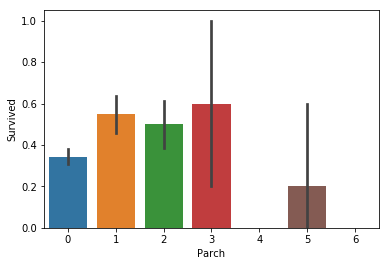

In [129]:
# 父母与子女数适中的乘客幸存率更高
sns.barplot(x = 'Parch',y = 'Survived',data = train)

Text(12.359751157407416, 0.5, 'density')

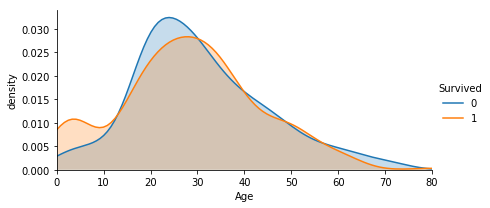

In [130]:
#FacetGrid用于绘制各变量之间的关系图
'''从不同生还情况的密度图可以看出，在年龄15岁的左侧，生还率有明显的区别，密度图非交叉区域面积非常大，但在其他年龄
段，则区别不是很明显，认为是随机所致，因此可以考虑将此年龄偏小的区域分离出来'''
facet = sns.FacetGrid(train,hue = 'Survived',aspect=2)  #hue变量名 aspect综合比
facet.map(sns.kdeplot,'Age',shade = True)  #kdeplot 核密度估计图 有阴影
facet.set(xlim = (0,train['Age'].max()))
facet.add_legend()  #右侧标签
plt.xlabel('Age')   #添加横纵坐标
plt.ylabel('density')

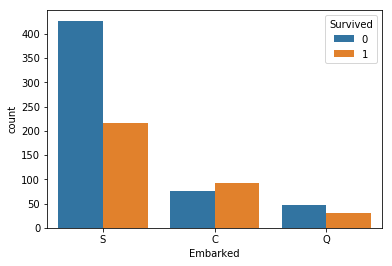

In [11]:
# Embarked 登港港口与生存情况的分析 结果分析：C地的生存率更高 保留为模型特征
sns.countplot('Embarked',hue = 'Survived',data = train)  # countplot 以bar的形式展示每个类别的数量 
#统计data中‘Embarked’这个特征每种类别的数量

#### Title Feature(new) 不同称呼的乘客幸存率不同

In [131]:
# 新增Title特征 从姓名中提取乘客的称呼 归纳为六类
all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip()) 
#strip() 移除字符串头尾指定的字符（默认为空格或换行符)
Title_Dict = {}
# update() 函数把字典dict2的键/值对更新到dict里。
#dict.fromkeys() 函数用于创建一个新字典，以序列 seq 中元素做字典的键，value 为字典所有键对应的初始值。
Title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'Officer'))
Title_Dict.update(dict.fromkeys(['Don','Sir','the Countess','Done','Lady'],'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle','Miss'],'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'],'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'],'Master'))

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


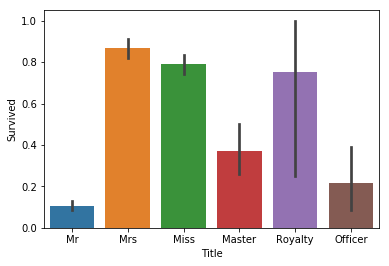

In [69]:
all_data['Title'] = all_data['Title'].map(Title_Dict)#此时只剩下称呼
sns.barplot(x = 'Title', y = 'Survived',data = all_data)

#### familylabel feature(new) 家庭人数2-4的乘客幸存率较高

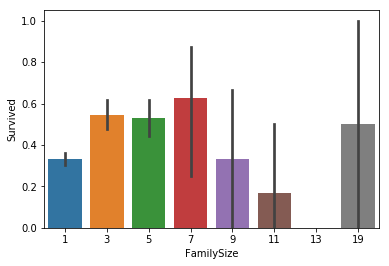

In [132]:
# 新增family label,先计算fanilylabel = parch + sibSp + 1 然后将familysize 分为三类
all_data['FamilySize'] = all_data['Parch'] + all_data['Parch'] + 1
sns.barplot(x = 'FamilySize', y = 'Survived',data = all_data)

In [49]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
FamilySize     1309 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 133.0+ KB


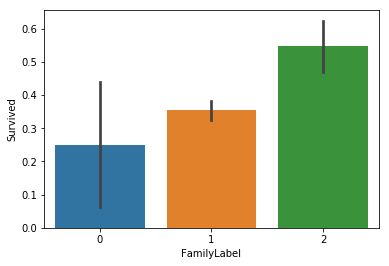

In [134]:
#按生存率把familysize 分为三类 构成familylabel
def Fam_label(s):
    if (s >= 2)& (s <= 4):
        return 2
    elif ((s>4) & (s <= 7)) | (s == 1):
        return 1
    elif (s>7):
        return 0

all_data['FamilyLabel'] = all_data['FamilySize'].apply(Fam_label)
sns.barplot(x = 'FamilyLabel' ,y = 'Survived', data = all_data)

#### Deck Feature 不同甲板的乘客幸存率不同  新增Deck特征，先把Cabin空缺值填充为Unknown,再提取Cabin中的首字母构成乘客的甲板号

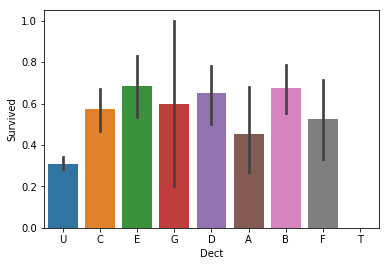

In [135]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown') #填充缺失值
all_data['Dect'] = all_data['Cabin'].str.get(0)
sns.barplot(x = 'Dect', y = 'Survived',data = all_data)

#### TicketGroup Feature 2-4共票号的乘客幸存率较高
#### 新增TicketGroup特征 统计每个乘客的共票号数

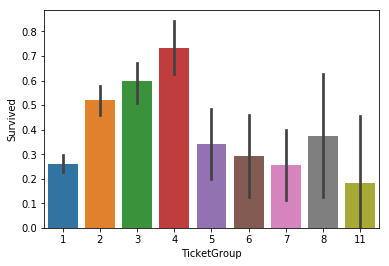

In [136]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x = 'TicketGroup',y = 'Survived',data = all_data)

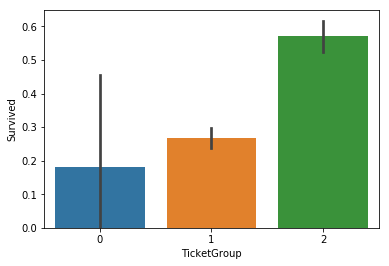

In [137]:
#按生存率把TicketGroup分为三类
def Ticket_Label(s):
    if (s>=2) & (s<=4):
        return 2
    elif ((s>4) & (s<=8)) | (s == 1):
        return 1
    elif (s>8):
        return 0
all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x = 'TicketGroup', y = 'Survived', data = all_data)

## 数据清洗
### 缺失值填充

In [138]:
# Age Feature ：Age缺失量为263 用Sex Title Pclass 三个特征构建随机森林模型 填充年龄缺失值
from sklearn.ensemble import RandomForestRegressor

In [139]:
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Dect,TicketGroup
0,22.0,Unknown,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,Mr,1,1,U,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,Mrs,1,1,C,2
2,26.0,Unknown,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,Miss,1,1,U,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,Mrs,1,1,C,2
4,35.0,Unknown,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,Mr,1,1,U,1


In [140]:
# 通过随机森林对缺失值Age进行预测
age_df = all_data[['Age','Sex','Title','Pclass']]
age_df = pd.get_dummies(age_df) # get_dummies是利用pandas实现one-hot encode的方式
known_age = age_df[age_df.Age.notnull()].as_matrix()  #提取数据中Age不为空的数据 转化为ndarray格式
unknown_age = age_df[age_df.Age.isnull()].as_matrix() #提取数据中Age为空的数据 转化为ndarray格式
y = known_age[:,0]  # 年龄
X = known_age[:,1:] # 除Age之后的One-hot 编码
rfr = RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1) #random_state随机数种子 
# n_estimator 随时树个数100 n_jobs 决定的使用的CPU内核个数 -1默认为调用所有内核
rfr.fit(X,y)  #训练
predictAges = rfr.predict(unknown_age[:,1::])
all_data.loc[(all_data.Age.isnull()),'Age'] = predictAges  #.loc通过行标签索引数据

D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


####  Embarked Feature 缺失量为2 缺失Embarked 信息的乘客的Pclass 均为1 且Fare均为80 因为Embarked 为C且Pclass为1的乘客的Fare中位数为80 所以缺失值为C

In [141]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Dect,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1,113572,Mrs,1,1,B,2


In [142]:
all_data.groupby(by = ['Pclass','Embarked']).Fare.median() #将all_data按照Pclass Embarked分类 求Fare的中位数

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [143]:
# 缺失值填充为C
all_data['Embarked'] = all_data['Embarked'].fillna('C')

 #### Fare Feature:Fare缺失量为1 缺失Fare信息的乘客的Embarked为S Pclass为3 所以为Embarked为3 Pclass为3的乘客的Fare中位数

In [144]:
all_data[all_data['Fare'].isnull()]  #Fare缺失的数据

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Dect,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,0,3701,Mr,1,1,U,1


In [145]:
# Embarked = S 和 Pclass = 3 的中位数
fare = all_data[(all_data['Embarked'] == 'S') & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare'] = all_data['Fare'].fillna(fare)

#### 同组识别 把姓氏相同的乘客划分为一组 从人数大于1的组中分别提取出每组的妇女儿童和成年男性

In [146]:
all_data['Surname'] = all_data['Name'].apply(lambda x : x.split(',')[0].strip())
# strip()方法用于移除字符串头尾指定的字符
Surname_Count = dict(all_data['Surname'].value_counts()) #对姓进行计数
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x]) #姓氏计数加入新的标签
Female_Child_Group = all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<= 12) | 
                                                                  (all_data['Sex']=='female'))]  
# 定位女性或者小孩
Male_Adult_Group = all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age'] > 12) & 
                                (all_data['Sex'] == 'male')]
# 定位成年男性

In [114]:
# 发现绝大部分女性和儿童的平均存活率为1或0 即同组的女性和儿童要么全部幸存要么全部遇难
Female_Child = pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts()) #平均存活率
Female_Child.columns = ['GroupCount']
Female_Child

,GroupCount
1.000000,152
0.000000,26
0.500000,7
0.666667,4
0.333333,3
0.600000,1
0.200000,1
0.166667,1
0.750000,1
0.250000,1


Text(0.5, 0, 'AverageSurvived')

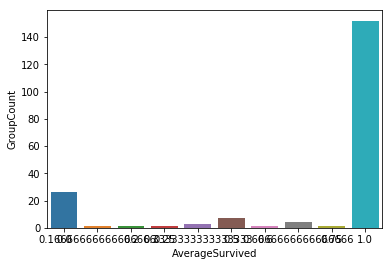

In [147]:
sns.barplot(x=Female_Child.index,y = Female_Child['GroupCount']).set_xlabel('AverageSurvived')

In [149]:
# 绝大部分成年男性组的平均存活率也为0或1
Male_Adult = pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns = ['GroupCount']
Male_Adult

,GroupCount
0.000000,171
1.000000,18
0.500000,7
0.333333,3
0.200000,1


In [119]:
'''因为普遍规律是女性和儿童幸存率高，成年男性幸存率较低，所以我们把不符合普遍规律的反常组选出来单独处理。把女性和
儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组，推测处于遇难组的女性和儿童幸存的可能性
较低，处于幸存组的成年男性幸存的成功性较高'''
Female_Child_Group = Female_Child_Group.groupby('Surname')['Survived'].mean() #按照姓分类并取平均值
Dead_List = set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)

KeyError: 'Column not found: Survived'

Surname
Abbott            1.000000
Abelseth          1.000000
Abelson           1.000000
Aks               0.500000
Allen             1.000000
Allison           0.333333
Andersson         0.250000
Andrews           1.000000
Angle             1.000000
Arnold-Franchi    0.000000
Asplund           0.600000
Astor             1.000000
Attalah           0.000000
Backstrom         1.000000
Baclini           1.000000
Barbara           0.000000
Baxter            1.000000
Beane             1.000000
Becker            1.000000
Beckwith          1.000000
Betros            0.000000
Bishop            1.000000
Bonnell           1.000000
Boulos            0.000000
Bourke            0.000000
Bowen             1.000000
Bradley           1.000000
Brown             1.000000
Bryhl             1.000000
Buckley           1.000000
                    ...   
Spencer           1.000000
Stanley           1.000000
Stengel           1.000000
Straus            1.000000
Strom             0.000000
Taussig           1.